In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

# 데이터 수집 및 전처리

In [42]:
# data를 불러옴
big_mart_data = pd.read_csv('/kaggle/input/bigmart-sales-data/Train.csv')

In [43]:
# 데이터 확인하기
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [44]:
# 데이터 shape 확인하기
big_mart_data.shape

(8523, 12)

In [45]:
# 데이터 info 찍어보기
big_mart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


## 분류화 된 데이터 컬럼들
- Item_Identifier
- Item_Fat_Content
- Item_Type
- Outlet_Identifier
- Outlet_Size
- Outlet_Location_Type
- Outlet_Type

In [46]:
# 결측치 확인
big_mart_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

결측치 처리를 어떻게 진행할 것인가

Mean --> 평균
Mode --> 최빈값

In [47]:
# 'Item_Weight' 컬럼의 평균
big_mart_data['Item_Weight'].mean()

12.857645184135976

In [48]:
# 'Item_weight' 컬럼의 결측치를 평균으로 대치
big_mart_data['Item_Weight'] = big_mart_data['Item_Weight'].fillna(big_mart_data['Item_Weight'].mean())

In [49]:
# 'Outlet_Size' 컬럼의 최빈값 확인, Medium 인 것을 확인함
big_mart_data['Outlet_Size'].mode()

0    Medium
Name: Outlet_Size, dtype: object

In [50]:
# Outlet_Size Pivot_table을 활용해서 Mode_of_Outlet_size를 선언
mode_of_Outlet_size = big_mart_data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))

피봇 테이블??
[피봇테이블_관련 블로그](https://yganalyst.github.io/data_handling/Pd_14/)

In [51]:
print(mode_of_Outlet_size)

Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


In [52]:
miss_values = big_mart_data['Outlet_Size'].isnull()

In [53]:
print(miss_values)

0       False
1       False
2       False
3        True
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool


In [54]:
big_mart_data.loc[miss_values, 'Outlet_Size'] = big_mart_data.loc[miss_values,'Outlet_Type'].apply(lambda x: mode_of_Outlet_size[x])
# outlet_size 컬럼 결측치들을 채워나감 

해당 코드 설명

big_mart_data.loc[miss_values, 'Outlet_Type'].apply(lambda x: mode_of_Outlet_size[x]): 이 부분에서는 'miss_values'로 지정된 행의 'Outlet_Type' 열에 대해 함수를 적용합니다. 여기서 사용된 람다 함수 lambda x: mode_of_Outlet_size[x]는 'Outlet_Type' 열의 각 값 'x'를 받아서, 'x'에 해당하는 'Outlet_Size'의 최빈값을 딕셔너리 mode_of_Outlet_size에서 찾아서 반환합니다. 이 딕셔너리는 각 매장 유형('Outlet_Type')에 따른 가장 흔한 매장 크기('Outlet_Size')를 저장하고 있습니다.

In [55]:
# 결측치를 확인
big_mart_data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

Data Analysis

In [56]:
big_mart_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


## 수치형 데이터

In [57]:
sns.set()

/tmp/ipykernel_33/1231822472.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(big_mart_data['Item_Weight'],kde= True)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


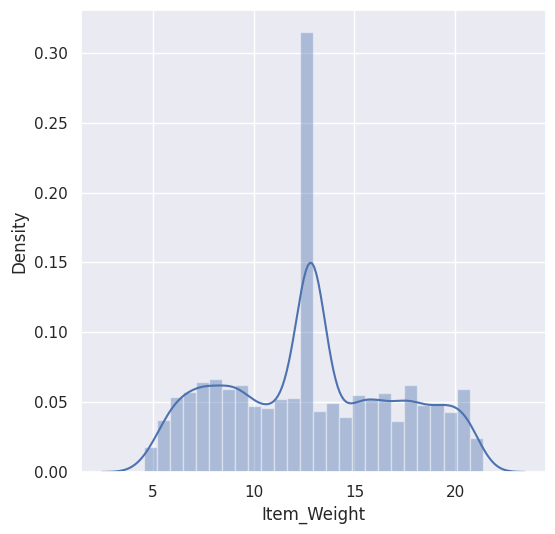

In [58]:
# Item_Weight distribution, 중앙값이 확 튀어오르는 것을 확인

plt.figure(figsize=(6,6))
sns.distplot(big_mart_data['Item_Weight'],kde= True)
plt.show()

/tmp/ipykernel_33/3404464166.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(big_mart_data['Item_Visibility'])
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


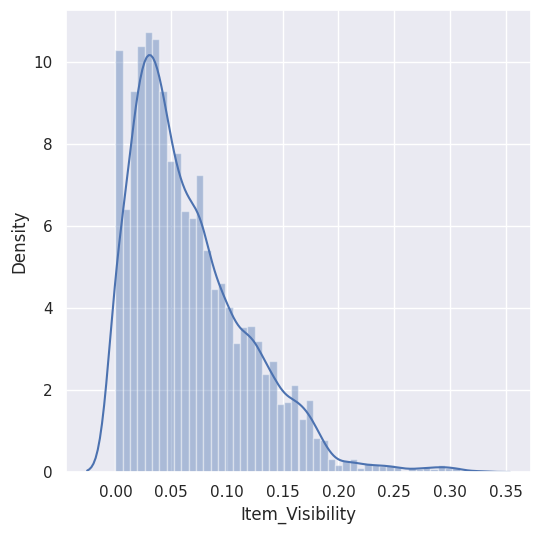

In [59]:
# Item Visibility 좌측 편향 관측
plt.figure(figsize=(6,6))
sns.distplot(big_mart_data['Item_Visibility'])
plt.show()

/tmp/ipykernel_33/3902246800.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(big_mart_data['Item_MRP'])
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


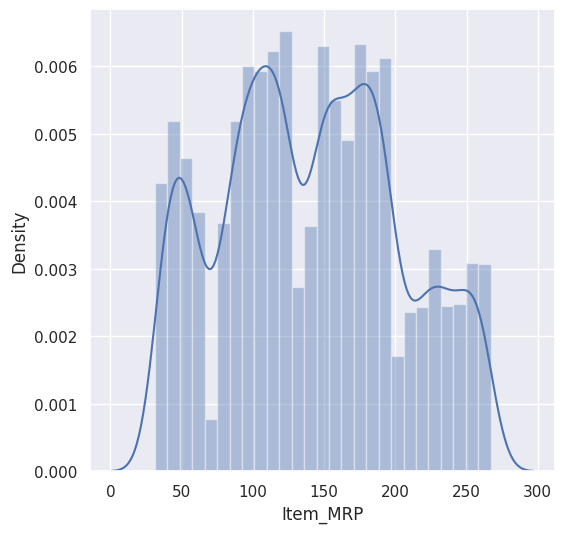

In [60]:
# Item MRP 분포 확인
plt.figure(figsize=(6,6))
sns.distplot(big_mart_data['Item_MRP'])
plt.show()

In [ ]:
# Item_Outlet_Sales, 제품 판매량의 좌측 쏠림현상 관측, 예측변수
plt.figure(figsize=(6,6))
sns.distplot(big_mart_data['Item_Outlet_Sales'])
plt.show()

In [ ]:
# Outlet_Establishment_Year 1985년 ~ 2009년 
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Establishment_Year', data=big_mart_data)
plt.show()

## 범주형 데이터

In [ ]:
# Item_Fat_Content column Low Fat, Regular, low_fat, LF,.reg
# 같은 뜻인데 시대 변화에 따라 혹은 표기 방식에 따라 변화가 있다.
plt.figure(figsize=(6,6))
sns.countplot(x='Item_Fat_Content', data=big_mart_data)
plt.show()

In [ ]:
# Item_Type column
plt.figure(figsize=(32,10))
sns.countplot(x='Item_Type', data=big_mart_data)
plt.show()

In [ ]:
# Outlet_Size column
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Size', data=big_mart_data)
plt.show()

In [ ]:
plt.figure(figsize=(6,6))
sns.countplot(x= 'Outlet_Location_Type', data = big_mart_data)
plt.show()

## 시각화 클래스

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class DataVisualizer:
    def __init__(self):
        plt.style.use('seaborn-darkgrid')  # Set a style for all plots

    def plot_feature_importance(self, importances, feature_names, title='Feature Importance'):
        indices = np.argsort(importances)
        sorted_features = [feature_names[i] for i in indices]
        
        plt.figure(figsize=(10, 6))
        plt.title(title)
        plt.barh(range(len(indices)), importances[indices], color='b', align='center')
        plt.yticks(range(len(indices)), sorted_features)
        plt.xlabel('Relative Importance')
        plt.show()

    def plot_model_comparison(self, results_df, title='Model Comparison'):
        results_df.plot(kind='bar', figsize=(14, 7))
        plt.title(title)
        plt.ylabel('Score')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend(loc='lower right')
        plt.show()

    def plot_correlation_matrix(self, df, title='Correlation Matrix'):
        plt.figure(figsize=(12, 10))
        sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
        plt.title(title)
        plt.show()

    def plot_pca_variance(self, pca, title='Explained Variance by PCA Components'):
        plt.figure(figsize=(8, 6))
        plt.plot(np.cumsum(pca.explained_variance_ratio_))
        plt.xlabel('Number of Components')
        plt.ylabel('Total Explained Variance')
        plt.title(title)
        plt.axhline(y=0.95, color='r', linestyle='--')
        plt.show()

    def plot_pca_components(self, X_pca, y, title='PCA Component Scatter Plot'):
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, alpha=0.8, cmap='viridis')
        plt.xlabel('First Principal Component')
        plt.ylabel('Second Principal Component')
        plt.colorbar(scatter)
        plt.title(title)
        plt.show()


## Data 전처리

In [ ]:
big_mart_data.head()

In [ ]:
big_mart_data['Item_Fat_Content'].value_counts()

Low Fat = LF = low fat 이다. 그리고 Regular = reg 이다. 그러니 데이터를 통합하는 전처리 과정을 수행한다.

In [ ]:
big_mart_data.replace({'Item_Fat_Content': {'low fat':'Low Fat','LF':'Low Fat', 'reg':'Regular'}}, inplace=True)

In [ ]:
# 데이터를 두 개의 범주로 나누었다. Low Fat : 5517 , Regular : 3006으로 통합 완료
big_mart_data['Item_Fat_Content'].value_counts()

## 라벨 인코딩 + 원핫인코딩

In [ ]:
df_label_onehot = big_mart_data.copy()
label_encoders = {}
label_features = ['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type']


for col in label_features:
    le = LabelEncoder()
    big_mart_data[col] = le.fit_transfrom(big_mard_data[col])
    label_encoders[col] = le

one_hot_features = ['Item_Type', 'Outlet_Type']
df_label_onehot = pd.get_dummies(df_label_onehot, columns=one_hot_features)

print(df_label_onehot.head())



## 라벨인코딩

In [ ]:
# encoder = LabelEncoder()

In [ ]:
# big_mart_data['Item_Identifier'] = encoder.fit_transform(big_mart_data['Item_Identifier'])

# big_mart_data['Item_Fat_Content'] = encoder.fit_transform(big_mart_data['Item_Fat_Content'])

# big_mart_data['Item_Type'] = encoder.fit_transform(big_mart_data['Item_Type'])

# big_mart_data['Outlet_Identifier'] = encoder.fit_transform(big_mart_data['Outlet_Identifier'])

# big_mart_data['Outlet_Size'] = encoder.fit_transform(big_mart_data['Outlet_Size'])

# big_mart_data['Outlet_Location_Type'] = encoder.fit_transform(big_mart_data['Outlet_Location_Type'])

# big_mart_data['Outlet_Type'] = encoder.fit_transform(big_mart_data['Outlet_Type'])

In [ ]:
# big_mart_data.head()

## 데이터 분할

In [ ]:
X = big_mart_data.drop(columns='Item_Outlet_Sales', axis=1)
Y = big_mart_data['Item_Outlet_Sales']

In [ ]:
print(X)

In [ ]:
print(Y)

## Splitting the data into Training data & Testing Data

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [ ]:
print(X.shape, X_train.shape, X_test.shape)

# 머신 러닝 모델 시작

## Model code Class

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np

# 모델들을 클래스화 했습니다. 사용하는데 편하지 않을까요? 자주쓰는 모델들은 대부분 불러왔습니다.
# 지원하는 모델은 def initaliz~ 코드를 확인해주시면됩니당
class CustomModel(BaseEstimator, RegressorMixin):
    def __init__(self, model_type='linear_regression'):
        """
        Initialize the CustomModel with a specified model type.
        :param model_type: str, the type of model to use ('random_forest', 'linear_regression', 'svr', 'xgboost', 'gradient_boosting', 'decision_tree', 'knn', 'elastic_net')
        """
        self.model_type = model_type
        self.model = None
        
    # 전처리 부분도 함수를 선언해놓긴 했습니다. 그러나 각자 전처리 방법이 다를 것 같아
    # train_X 데이터를 그냥 사용하는 식으로 작성했습니다.
    def preprocess(self, X):
        """
        Handle all preprocessing steps like feature encoding, normalization, etc.
        Modify this method as needed when preprocessing changes.
        :param X: DataFrame, features to be preprocessed
        :return: DataFrame, preprocessed features
        """
        return X  
    
    def fit(self, X, y):
        """
        Fit the model according to the given training data.
        :param X: DataFrame, training features
        :param y: Series, training target
        """
        X_preprocessed = self.preprocess(X)
        # Model initialization based on the model_type
        self.initialize_model()
        self.model.fit(X_preprocessed, y)
    
    def predict(self, X):
        """
        Predict using the model.
        :param X: DataFrame, features for prediction
        :return: array, predictions
        """
        X_preprocessed = self.preprocess(X)
        return self.model.predict(X_preprocessed)
    
    def score(self, X, y):
        """
        Returns the R-squared score of the prediction.
        :param X: DataFrame, test features
        :param y: Series, true values
        :return: float, R-squared score
        """
        predictions = self.predict(X)
        return r2_score(y, predictions)

    def initialize_model(self):
        """
        Initialize the specific type of model based on model_type attribute.
        """
        if self.model_type == 'random_forest':
            self.model = RandomForestRegressor(n_estimators=100, random_state=42)
        elif self.model_type == 'linear_regression':
            self.model = LinearRegression()
        elif self.model_type == 'svr':
            self.model = SVR(kernel='rbf')
        elif self.model_type == 'xgboost':
            self.model = XGBRegressor(objective='reg:squarederror')
        elif self.model_type == 'gradient_boosting':
            self.model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
        elif self.model_type == 'decision_tree':
            self.model = DecisionTreeRegressor(random_state=42)
        elif self.model_type == 'knn':
            self.model = KNeighborsRegressor()
        elif self.model_type == 'elastic_net':
            self.model = ElasticNet(random_state=42)
        else:
            raise ValueError("Unsupported model type")

    # 중요변수를 출력하는 부분들을 추가했습니다. 다만 모든 모델이 지원하지는 않습니다.
    # 지원하지 않는 모델의 경우에는 경고문을 출력할 수 있게 작성했습니다.
    # 그리고 중요 변수를 그래프 형태로 볼 수 있도록 작성했습니다.
    def get_feature_importance(self, feature_names):
        """
        Retrieve and plot feature importance from the model if available.
        :param feature_names: list, names of the features used for model training
        """
        if hasattr(self.model, 'feature_importances_'):
            importances = self.model.feature_importances_
        elif hasattr(self.model, 'coef_'):
            importances = np.abs(self.model.coef_)
        else:
            print("Feature importance not supported for this model type.")
            return
        
        # Create a bar chart of the feature importances
        plt.figure(figsize=(10, 6))
        indices = np.argsort(importances)
        plt.title('Feature Importances')
        plt.barh(range(len(indices)), importances[indices], color='b', align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()


# Example usage:
# feature_names = X_train.columns.tolist()
# model = CustomModel(model_type='xgboost')
# model.fit(X_train, Y_train)
# print("Training score:", model.score(X_train, Y_train))
# print("Test score:", model.score(X_test, Y_test))
# print("Feature Importances:",model.get_feature_importance(feature_names))

In [ ]:
feature_names = X_train.columns.tolist()
model = CustomModel(model_type='xgboost')
model.fit(X_train, Y_train)
print("Training score:", model.score(X_train, Y_train))
print("Test score:", model.score(X_test, Y_test))
print("Feature Importances:",model.get_feature_importance(feature_names))

## 전체 모델 확인

In [ ]:
# Assuming CustomModel class is already defined and imported
model_types = ['random_forest', 'linear_regression', 'svr', 'xgboost', 'gradient_boosting', 'decision_tree', 'knn', 'elastic_net']

# Dictionary to store the results
results = {}

# Iterate over each model type, fit, predict, and display results
for model_type in model_types:
    print(f"Results for {model_type}:")
    model = CustomModel(model_type=model_type)
    model.fit(X_train, Y_train)
    train_score = model.score(X_train, Y_train)
    test_score = model.score(X_test, Y_test)
    
    # Storing results
    results[model_type] = {'Training Score': train_score, 'Test Score': test_score}
    
    # Output scores
    print(f"Training Score: {train_score:.4f}")
    print(f"Test Score: {test_score:.4f}")
    
    # Feature Importance - Only if applicable
    if model_type not in ['svr', 'knn']:  # Assuming SVR and KNN don't support feature importance in your implementation
        print("Feature Importances:")
        model.get_feature_importance(X_train.columns)
    print("\n" + "-"*60 + "\n")

# Optionally, convert results to a DataFrame for better visualization or further analysis
import pandas as pd
results_df = pd.DataFrame(results).T
print(results_df)


## PCA 버전

### PCA_CustomModel 클래스화

In [ ]:
from sklearn.decomposition import PCA
## OOP 적용
class PCA_CustomModel(CustomModel):
    def __init__(self, model_type='linear_regression', n_components=None):
        super().__init__(model_type=model_type)
        self.n_components = n_components
        self.pca = PCA(n_components=self.n_components) if self.n_components else None

    def fit(self, X, y):
        if self.pca:
            X = self.pca.fit_transform(X)
        super().fit(X, y)

    def predict(self, X):
        if self.pca:
            X = self.pca.transform(X)
        return super().predict(X)

    def score(self, X, y):
        return super().score(X, y)

In [ ]:
from sklearn.model_selection import train_test_split

# Example data split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Models to test
model_types = ['random_forest', 'linear_regression', 'svr', 'xgboost', 'gradient_boosting', 'decision_tree', 'knn', 'elastic_net']
n_components = 5  # or dynamically determine based on explained variance ratio

# Dictionary to store results
results = {}

for model_type in model_types:
    pca_model = PCA_CustomModel(model_type=model_type, n_components=n_components)
    pca_model.fit(X_train, Y_train)
    train_score = pca_model.score(X_train, Y_train)
    test_score = pca_model.score(X_test, Y_test)
    
    results[model_type] = {
        'Train Score': train_score,
        'Test Score': test_score
    }
    print(f"Model: {model_type}, Train Score: {train_score}, Test Score: {test_score}")

# Displaying the results in a DataFrame for better visualization
results_df = pd.DataFrame(results).T
print(results_df)
